In [1]:
%pip install --quiet mesa

In [2]:
!pip install matplotlib

In [3]:
import mesa
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as pltdef_step

In [4]:
def compute_gini(model):
  agent_wealths = [agent.wealth for agent in model.schedule.agents]
  x = sorted(agent_wealths)
  N = model.num_agents
  B = sum(xi * (N-i) for i, xi in enumerate(x)) / (N * sum(x))
  return 1 + (1/N) - 2 * B

class MoneyAgent(mesa.Agent):
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.wealth = 1
  def step(self):
    self.move()
    if self.wealth > 0:
      self.give_money()
  def move(self):
    possible_steps = self.model.grid.get_neighborhood(
        self.pos, moore = True, include_center = False
    )
    new_position = self.random.choice(possible_steps)
    self.model.grid.move_agent(self, new_position)
  def give_money(self):
    cellmates = self.model.grid.get_cell_list_contents([self.pos])
    if len(cellmates) > 1:
      other = self.random.choice(cellmates)
      other.wealth += 1
      self.wealth -= 1


class MoneyModel(mesa.Model):
  def __init__(self, N, width, height):
    self.num_agents = N
    self.grid = mesa.space.MultiGrid(width, height, True)
    self.schedule = mesa.time.RandomActivation(self)
    self.running = True
    for i in range(self.num_agents):
      a = MoneyAgent(i,self)
      self.schedule.add(a)

      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)
      self.grid.place_agent(a, (x,y))
      self.datacollector = mesa.DataCollector(
          model_reporters = {"Gini": compute_gini}, agent_reporters = {"Wealth": "wealth"}
      )

  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()


In [5]:
model = MoneyModel(100, 10, 10)
for i in range(100):
  model.step()

[Text(0.5, 1.0, 'Gini Coefficient over Time'),
 Text(0, 0.5, 'Gini Coefficient')]

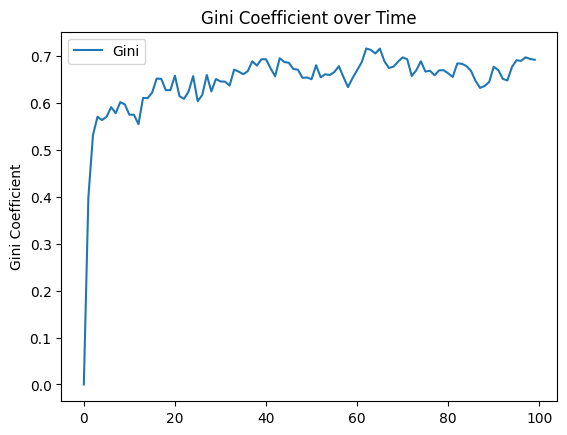

In [6]:
gini = model.datacollector.get_model_vars_dataframe()
g = sns.lineplot(data = gini)
g.set(title="Gini Coefficient over Time", ylabel = "Gini Coefficient")

In [7]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

[Text(0.5, 1.0, 'Wealth dist at end of simul'),
 Text(0.5, 0, 'Wealth'),
 Text(0, 0.5, 'Number of agents')]

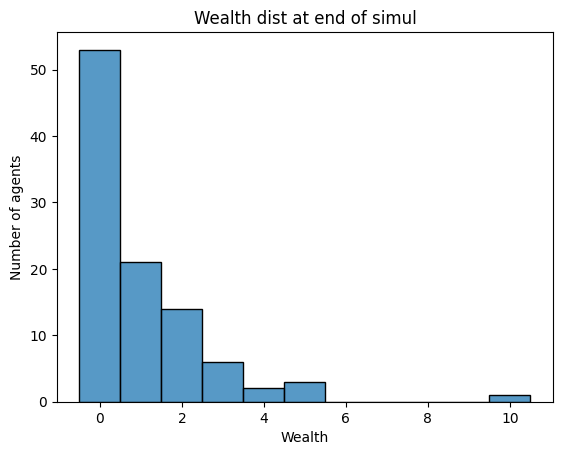

In [8]:
last_step = agent_wealth.index.get_level_values("Step").max()
end_wealth = agent_wealth.xs(last_step, level = "Step")["Wealth"]

g = sns.histplot(end_wealth, discrete=True)
g.set(title = "Wealth dist at end of simul", xlabel = "Wealth", ylabel = "Number of agents")

[Text(0.5, 1.0, 'Wealth of agent 14 over time')]

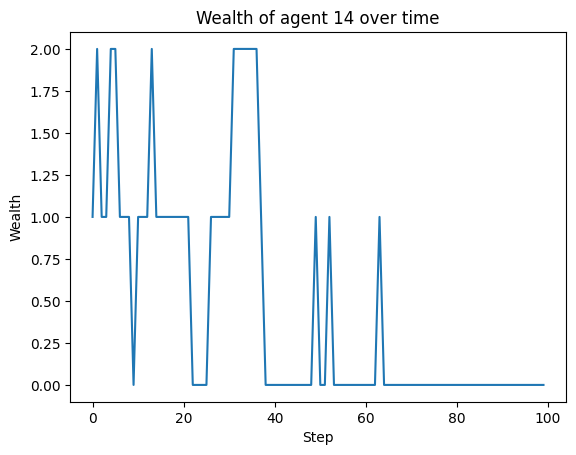

In [9]:
agent_14_wealth = agent_wealth.xs(14, level="AgentID")
g=sns.lineplot(data = agent_14_wealth, x="Step", y="Wealth")
g.set(title="Wealth of agent 14 over time")

In [10]:
gini.head()

,Gini
0,0.0000
1,0.3986
2,0.5306
3,0.5700
4,0.5630


[Text(0.5, 1.0, 'Number of agents on each cell of grid')]

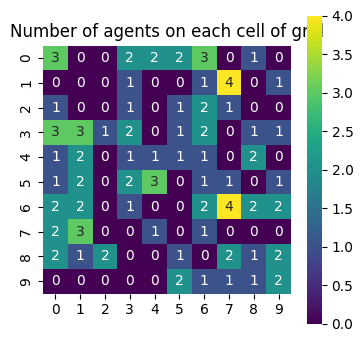

In [11]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x,y) in model.grid.coord_iter():
  agent_count = len(cell_content)
  agent_counts[x][y] = agent_count

hmap = sns.heatmap(agent_counts, cmap = "viridis", annot=True, cbar = True, square = True)
hmap.figure.set_size_inches(4,4)
hmap.set(title="Number of agents on each cell of grid")


In [12]:
params = {"width" : 10, "height": 10, "N": range(10, 500,10)}

results = mesa.batch_run(
    MoneyModel,
    parameters = params,
    iterations = 5,
    max_steps = 100,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

100%|██████████| 245/245 [00:48<00:00,  5.07it/s]


In [13]:
results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Gini', 'AgentID',
       'Wealth'],
      dtype='object')


In [14]:
results_df.head()

,RunId,iteration,Step,width,height,N,Gini,AgentID,Wealth
0,0,0,0,10,10,10,0.0,0,1
1,0,0,0,10,10,10,0.0,1,1
2,0,0,0,10,10,10,0.0,2,1
3,0,0,0,10,10,10,0.0,3,1
4,0,0,0,10,10,10,0.0,4,1


[Text(0.5, 0, 'Num Agents'),
 Text(0, 0.5, 'Gini Coefficient'),
 Text(0.5, 1.0, 'Gini Coefficient vs Num of Agents')]

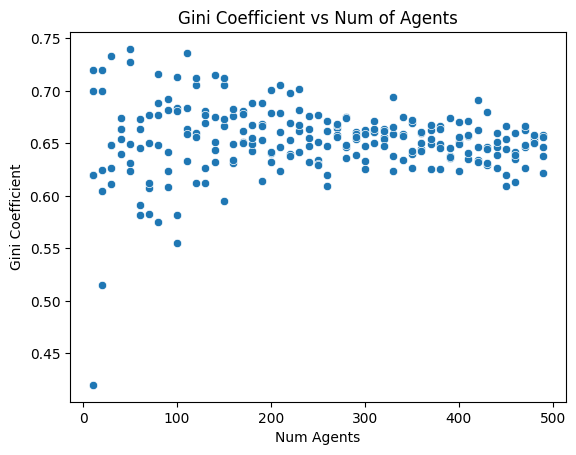

In [15]:
results_filtered = results_df[(results_df.AgentID == 0) & (results_df.Step == 100)]
results_filtered[["iteration", "N", "Gini"]].reset_index(
 drop=True
).head()

g = sns.scatterplot(data=results_filtered, x="N", y="Gini")
g.set(xlabel = "Num Agents", ylabel = "Gini Coefficient", title = "Gini Coefficient vs Num of Agents")

In [16]:
one_episode_wealth = results_df[(results_df.N == 10) & (results_df.iteration == 2)]

print(
    one_episode_wealth.to_string(
        index = False, columns = ["Step", "AgentID", "Wealth"], max_rows=25
    )
)

 Step  AgentID  Wealth
    0        0       1
    0        1       1
    0        2       1
    0        3       1
    0        4       1
    0        5       1
    0        6       1
    0        7       1
    0        8       1
    0        9       1
    1        0       1
    1        1       1
  ...      ...     ...
   99        8       2
   99        9       0
  100        0       1
  100        1       0
  100        2       1
  100        3       1
  100        4       0
  100        5       2
  100        6       2
  100        7       1
  100        8       2
  100        9       0


In [17]:
results_one_episode = results_df[
    (results_df.N == 10) & (results_df.iteration == 1) & (results_df.AgentID == 0)
]
print(results_one_episode.to_string(index = False, columns = ["Step", "Gini"], max_rows = 25))

 Step  Gini
    0  0.00
    1  0.00
    2  0.00
    3  0.00
    4  0.00
    5  0.00
    6  0.18
    7  0.18
    8  0.32
    9  0.46
   10  0.46
   11  0.46
  ...   ...
   89  0.70
   90  0.70
   91  0.70
   92  0.70
   93  0.70
   94  0.70
   95  0.70
   96  0.70
   97  0.70
   98  0.70
   99  0.70
  100  0.70


In [18]:
def agent_portrayal(agent):
  return {
      "color": "tab:blue",
      "size": 50
  }

model_params = {
      "N": {
          "type": "SliderInt",
          "value": 50,
          "label": "Number of Agents",
          "min": 10,
          "max": 100,
          "step": 1
      },
      "width": 10,
      "height": 10
  }

In [19]:
from mesa.experimental import JupyterViz

page = JupyterViz(
    MoneyModel,
    model_params,
    measures = ["Gini"],
    name = "Money Model",
    agent_portrayal=agent_portrayal
)

page

Html(layout=None, style_='display: none', tag='span')

Cannot show ipywidgets in text